In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Descriptors import MoleculeDescriptors
from GCN import GCN
import numpy as np
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# data loading
train_y = torch.zeros(1025)
train_x = []
train_adj_x = torch.zeros((1025,50,50))
a = 0
c = 0
elements = set()
with open("./datasets/solubility.train.sdf") as f:
    f.readline()
    f.readline()
    f.readline()
    b = f.readline().split()
    x = int(b[0])
    y = int(b[1])
    tmp = []
    for i in range(x):
        b = f.readline().split()
        tmp.append(b[:4])
        elements.add(b[3])
    train_x.append(tmp)
    for i in range(y):
        b = list(map(int,f.readline().split()))
        n,m,k,_ = b
        n-=1;m-=1
        train_adj_x[c][n][m] = k
        train_adj_x[c][m][n] = k
    c+=1
    while True:
        s_line = f.readline()
        if s_line.find("$$$$") != -1:
            f.readline()
            f.readline()
            f.readline()
            b = f.readline().split()
            if b == []:
                break
            x = int(b[0])
            y = int(b[1])
            tmp = []
            for i in range(x):
                b = f.readline().split()
                tmp.append(b[:4])
                elements.add(b[3])
            train_x.append(tmp)
            for i in range(y):
                b = list(map(int,f.readline().split()))
                n,m,k,_ = b
                n-=1;m-=1
                train_adj_x[c][n][m] = k
                train_adj_x[c][m][n] = k
            c+=1
        if s_line.find(">  <SOL>") != -1:
            b = f.readline()
            train_y[a] = float(b)
            a += 1
            
        if not s_line:
            break
            
test_y = torch.zeros(257)
test_x = []
test_adj_x = torch.zeros((257,50,50))
a = 0
c = 0
with open("./datasets/solubility.test.sdf") as f:
    f.readline()
    f.readline()
    f.readline()
    b = f.readline().split()
    x = int(b[0])
    y = int(b[1])
    tmp = []
    for i in range(x):
        b = f.readline().split()
        tmp.append(b[:4])
        elements.add(b[3])
    test_x.append(tmp)
    for i in range(y):
        b = list(map(int,f.readline().split()))
        n,m,k,_ = b
        n-=1;m-=1
        test_adj_x[c][n][m] = k
        test_adj_x[c][m][n] = k
    c+=1
    while True:
        s_line = f.readline()
        if s_line.find("$$$$") != -1:
            f.readline()
            f.readline()
            f.readline()
            b = f.readline().split()
            if b == []:
                break
            x = int(b[0])
            y = int(b[1])
            tmp = []
            for i in range(x):
                b = f.readline().split()
                tmp.append(b[:4])
                elements.add(b[3])
            test_x.append(tmp)
            for i in range(y):
                b = list(map(int,f.readline().split()))
                n,m,k,_ = b
                n-=1;m-=1
                test_adj_x[c][n][m] = k
                test_adj_x[c][m][n] = k
            c+=1
        if s_line.find("> <SOL>") != -1:
            b = f.readline()
            test_y[a] = float(b)
            a += 1
            
            
        if not s_line:
            break

In [3]:
elements = list(elements)
elen = len(elements)
def make_one_hot(char):
    one = np.zeros(elen)
    one[elements.index(char)] = 1
    return one
print(elen)
print(elements)

11
['F', 'P', 'I', 'N', 'Cl', 'S', 'H', 'Br', 'Sn', 'C', 'O']


In [4]:
descs = [desc_name[0] for desc_name in Descriptors._descList]
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)

In [5]:
train_x2 = torch.zeros(1025,50,13)
for i in range(1025):
    a = train_x[i]
    for j in range(len(a)):
        Mol = Chem.MolFromSmiles("["+a[j][3]+"]")
        train_x2[i][j][11] = Descriptors.MolWt(Mol)
        train_x2[i][j][12] = Descriptors.NOCount(Mol)
#        train_x2[i][j][16] = Descriptors.MolMR(Mol)
        train_x2[i][j][elements.index(a[j][3])] = 1
train_x = train_x2

In [6]:
test_x2 = torch.zeros(257,50,13)
for i in range(257):
    a = test_x[i]
    for j in range(len(a)):
        Mol = Chem.MolFromSmiles("["+a[j][3]+"]")
        test_x2[i][j][11] = Descriptors.MolWt(Mol)
        test_x2[i][j][12] = Descriptors.NOCount(Mol)
#        test_x2[i][j][16] = Descriptors.MolMR(Mol)
        test_x2[i][j][elements.index(a[j][3])] = 1
test_x = test_x2

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
for i in range(train_x.shape[2]):
    train_x[:,:,i] = torch.from_numpy(sc.fit_transform(train_x[:,:,i]))
    test_x[:,:,i] = torch.from_numpy(sc.transform(test_x[:,:,i]))

In [8]:
model = GCN(nfeat=train_x.shape[2],
            nnode = 50,
           nhid = 128,
           dropout=0.2)
optimizer = optim.Adam(model.parameters(),lr=(0.005))

In [9]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    
    def __init__(self,adj,features,ans):
        self.adj = adj
        self.features = features
        self.ans = ans
    
    def __len__(self):
        return len(self.adj)
    
    def __getitem__(self,idx):
        adj = self.adj[idx]
        feats = self.features[idx]
        ans = self.ans[idx]
        return adj,feats,ans

In [10]:
train_data= MyDataset(train_adj_x,train_x,train_y)
test_data= MyDataset(test_adj_x,test_x,test_y)

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(9)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [12]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data,sampler=valid_sampler,batch_size=1000)
test_loader = torch.utils.data.DataLoader(test_data)

In [13]:
best = float("inf")
def train(epoch):
    criterion = nn.MSELoss()
    model.train()
    for adj,feats,ans in train_loader:
        optimizer.zero_grad()
        output = model(feats,adj)
        loss_train = torch.sqrt(criterion(output,ans.view(-1,1)))
        loss_train.backward()
        optimizer.step()
    output = model(train_x,train_adj_x)
    print("Epoch: {:04d}".format(epoch+1),
         "loss_train: {:.4f}".format(mean_squared_error(output.detach().numpy(),train_y)**0.5))
    
    model.eval()
    for valid_adj_x,valid_x,valid_y in valid_loader:
        output = model(valid_x,valid_adj_x)
        tmp = mean_squared_error(output.detach().numpy(),valid_y)**0.5
        print(tmp)
        global best
        if best > tmp:
            best = tmp
            torch.save(model.state_dict(), "./solubility.model")
            
        
for epoch in range(100):
    train(epoch)

Epoch: 0001 loss_train: 1.6141
1.590559065076129
Epoch: 0002 loss_train: 1.0857
1.148709946059662
Epoch: 0003 loss_train: 1.0747
1.1055893040356342
Epoch: 0004 loss_train: 1.0038
1.0596752202709847
Epoch: 0005 loss_train: 0.9797
1.0049810926831886
Epoch: 0006 loss_train: 0.9624
0.9798027907679646
Epoch: 0007 loss_train: 0.9248
0.9699118937463891
Epoch: 0008 loss_train: 0.9072
0.9397682089821214
Epoch: 0009 loss_train: 0.8992
0.9188857348077999
Epoch: 0010 loss_train: 0.9355
0.9177231805114907
Epoch: 0011 loss_train: 0.9140
0.930212113279129
Epoch: 0012 loss_train: 0.8475
0.8213427295908522
Epoch: 0013 loss_train: 0.8314
0.8146642324434157
Epoch: 0014 loss_train: 0.8310
0.808736816133704
Epoch: 0015 loss_train: 0.7877
0.7423403130871077
Epoch: 0016 loss_train: 0.7675
0.7259275061140718
Epoch: 0017 loss_train: 0.8396
0.7968609378546325
Epoch: 0018 loss_train: 0.8254
0.8037833532291989
Epoch: 0019 loss_train: 0.7509
0.6895032005387922
Epoch: 0020 loss_train: 0.7663
0.7150417533100746
Epoc

In [14]:
model.load_state_dict(torch.load("./solubility.model"))

In [15]:
output = model(train_x,train_adj_x)
print("train_RMSE: {:.4f}".format(mean_squared_error(output.detach().numpy(),train_y)**0.5))
output = model(test_x,test_adj_x)
print("test_RMSE : {:.4f}".format(mean_squared_error(output.detach().numpy(),test_y)**0.5))

train_RMSE: 0.4812
test_RMSE : 0.6106


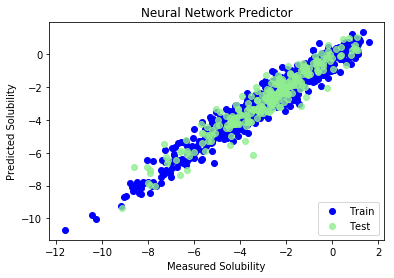

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(train_y, model(train_x,train_adj_x).detach().numpy(), label = 'Train', c = 'blue')
plt.title('Neural Network Predictor')
plt.xlabel('Measured Solubility')
plt.ylabel('Predicted Solubility')
plt.scatter(test_y, model(test_x,test_adj_x).detach().numpy(), c = 'lightgreen', label = 'Test', alpha = 0.8)
plt.legend(loc = 4)
plt.show()